# Conversational agent based on a seq2seq model with attention

## Setup environment if running in Google Colab

In [1]:
# %%bash
# git clone https://github.com/Paulescu/talking-machines.git
# mv talking-machines/* .
# rm -r talking-machines
# pip install -q -r requirements_py3.6.txt

In [1]:
from pathlib import Path

# data manipulation & visualization
import pandas as pd
import matplotlib.pyplot as plt

# deep-learning libraries
import torch

In [8]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set environment variables

In [3]:
if 'google.colab' in str(get_ipython()):
    print('Running in Colab')
    DATA_DIR = Path('/content/data')
    ARTIFACTS_DIR = Path('/content/drive/MyDrive/chatbot-course')
    VECTORS_CACHE_DIR = ARTIFACTS_DIR
    
    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print('Running in local')
    DATA_DIR = Path('./data')
    ARTIFACTS_DIR = Path('./artifacts')
    VECTORS_CACHE_DIR = Path('./.vector_cache')

Running in local


In [9]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print('GPU acceleration is available and will be used :-)')
else:
    DEVICE = torch.device("cpu")
    print('GPU is not available. If you are using Google Colab, change the runtime to GPU, otherwise training will '
          'take too long.')

GPU is not available. If you are using Google Colab, change the runtime to GPU, otherwise training will take too long.


## Download the data

In [14]:
%autoreload 2
from utils.data import download_data
download_data(DATA_DIR)

Downloading: 100% [209850483 / 209850483] bytes

## Generate train, val, test files

In [13]:
%autoreload 2
from utils.data import generate_train_val_test_files
generate_train_val_test_files(DATA_DIR/'personachat_self_original.json', autocorrect=False)

  0%|          | 0/17878 [00:00<?, ?it/s]

0 lines removed
Train set 122,499


  0%|          | 0/1000 [00:00<?, ?it/s]

0 lines removed
Test set 7,801
Saved /Users/paulabartabajo/src/online-courses/advanced-nlp-chatbot/data/train.csv
Saved /Users/paulabartabajo/src/online-courses/advanced-nlp-chatbot/data/val.csv
Saved /Users/paulabartabajo/src/online-courses/advanced-nlp-chatbot/data/test.csv


## Quick exploratory data analysis

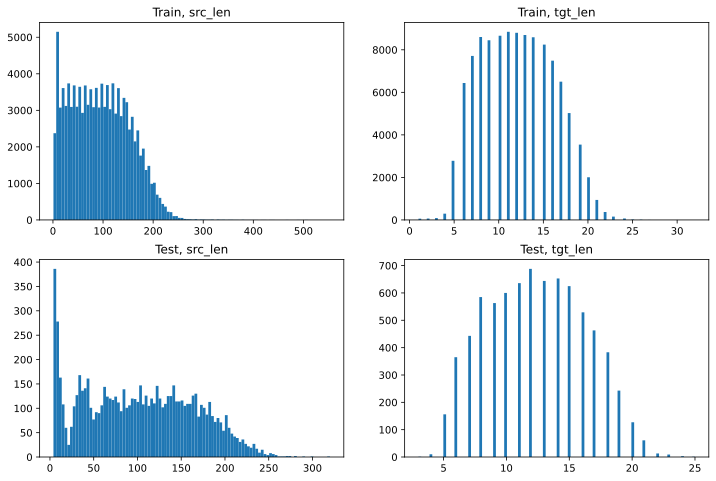

In [14]:
from utils.tokenizer import tokenizer

train = pd.read_csv(DATA_DIR/'train.csv', header=None)
train.columns = ['src', 'tgt']
train_src_len = train['src'].apply(lambda x: len(tokenizer(x)))
train_tgt_len = train['tgt'].apply(lambda x: len(tokenizer(x)))

test = pd.read_csv(DATA_DIR/'test.csv', header=None)
test.columns = ['src', 'tgt']
test_src_len = test['src'].apply(lambda x: len(tokenizer(x)))
test_tgt_len = test['tgt'].apply(lambda x: len(tokenizer(x)))

figure, ax = plt.subplots(2, 2, figsize=(12, 8))
# train
ax[0, 0].hist(train_src_len, bins=100)
ax[0, 0].set_title('Train, src_len')
ax[0, 1].hist(train_tgt_len, bins=100)
ax[0, 1].set_title('Train, tgt_len')

# test
ax[1, 0].hist(test_src_len, bins=100)
ax[1, 0].set_title('Test, src_len')
ax[1, 1].hist(test_tgt_len, bins=100)
ax[1, 1].set_title('Test, tgt_len')

plt.show()

## PyTorch datasets

In [11]:
%autoreload 2
from utils.data import get_datasets_and_vocab

train_dataset, validation_dataset, test_dataset, vocab = get_datasets_and_vocab(
    path_to_files=DATA_DIR,
    train='train.csv',
    validation='val.csv',
    test='test.csv',
    train_size=1000,
    validation_size=100,
    use_glove_vectors=True,
    vectors_cache=VECTORS_CACHE_DIR,
)

from utils.util import save_vocab
save_vocab(vocab, ARTIFACTS_DIR/f'vocab_{len(vocab)}')
print(f'Vocab size: {len(vocab):,}')

/Users/paulabartabajo/miniconda3/envs/chatbot_py3.6/lib/python3.6/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/Users/paulabartabajo/miniconda3/envs/chatbot_py3.6/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/Users/paulabartabajo/miniconda3/envs/chatbot_py3.6/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class w

Vocab size: 2,221


## Vocabulary

In [12]:
vocab.freqs

Counter({'hi': 530,
         ',': 2557,
         'how': 1075,
         'are': 1409,
         'you': 3320,
         'doing': 406,
         '?': 2959,
         'i': 6931,
         "'": 2024,
         'm': 1029,
         'getting': 37,
         'ready': 34,
         'to': 2092,
         'do': 1657,
         'some': 173,
         'cheetah': 7,
         'chasing': 14,
         'stay': 47,
         'in': 909,
         'shape': 7,
         '.': 13084,
         'must': 30,
         'be': 354,
         'very': 221,
         'fast': 11,
         'hunting': 25,
         'is': 1335,
         'one': 177,
         'of': 688,
         'my': 1749,
         'favorite': 270,
         'hobbies': 92,
         'am': 1052,
         '!': 1432,
         'for': 697,
         'hobby': 55,
         'like': 962,
         'canning': 10,
         'or': 116,
         'whittling': 6,
         'also': 126,
         'remodel': 6,
         'homes': 7,
         'when': 164,
         'not': 573,
         'out': 124,
     

## PyTorch DataLoaders

In [13]:
%autoreload 2
from utils.data import get_dataloaders

train_iter, validation_iter, test_iter = get_dataloaders(
    train_dataset, validation_dataset, test_dataset,
    batch_size=2400,
    device=DEVICE
)

x = next(iter(train_iter))
print('Example \n-------')
print(x.src[0])
print(x.src[1])

Example 
-------
tensor([[  2,   5,  20,  ...,   3,   1,   1],
        [  2,  34,   8,  ...,   1,   1,   1],
        [  2,  40,   8,  ...,   1,   1,   1],
        ...,
        [  2,  40,   8,  ...,   1,   1,   1],
        [  2,   5, 135,  ...,   1,   1,   1],
        [  2,  34,  19,  ...,   1,   1,   1]])
tensor([125, 124, 123, 122, 122, 122, 127, 123, 120, 120, 118, 121, 121, 118,
        117, 117, 114, 114, 114])


/Users/paulabartabajo/miniconda3/envs/chatbot_py3.6/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/Users/paulabartabajo/miniconda3/envs/chatbot_py3.6/lib/python3.6/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


## Model

In [11]:
%autoreload 2
from model import Seq2seqRNN
from utils.util import count_parameters

hidden_dim = 256
n_layers = 3
n_directions_encoder = 2
model = Seq2seqRNN(len(vocab),
                   vocab.vectors.shape[1],
                   hidden_dim,
                   n_layers,
                   n_directions_encoder,
                   dropout=0.2,
#                    pretrained_embeddings=vocab.vectors,
                   freeze_embeddings=False,
#                    attention_type='dot'
                  )

print(f'The model has {count_parameters(model):,} parameters')

The model has 5,476,657 parameters


## Train

In [14]:
%autoreload 2
from train import Seq2seqRNNTrainer
from utils.data import PAD_TOKEN

trainer = Seq2seqRNNTrainer(model,
                            train_iter,
                            validation_iter,
                            learning_rate=3e-4,
                            pad_token_id=vocab.stoi[PAD_TOKEN],
                            gradient_clip=1,
                            teacher_forcing=0.5,
                            checkpoint_dir=ARTIFACTS_DIR)
n_epochs = 10
trainer.train_test_loop(n_epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 000, Train loss: 6.1542, Val loss: 6.1182, Train ppl: 470.7, Val ppl: 454.1
artifacts/f04249a4-69a1-11eb-bc39-acbc32b70c09/0.ckpt was saved
artifacts/f04249a4-69a1-11eb-bc39-acbc32b70c09/params.json file was saved


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 001, Train loss: 6.1150, Val loss: 6.0492, Train ppl: 452.6, Val ppl: 423.8
artifacts/f04249a4-69a1-11eb-bc39-acbc32b70c09/1.ckpt was saved
artifacts/f04249a4-69a1-11eb-bc39-acbc32b70c09/params.json file was saved


## In case you want to resume training from a saved checkpoint

In [135]:
run_id = '<REPLACE_BY_RUN_ID>'
n_epochs = 10
trainer.load(run_id=run_id, epoch=1)

n_epochs = 2
trainer.train_test_loop(n_epochs)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 000, Train loss: 5.7879, Val loss: 4.7615, Train ppl: 326.3, Val ppl: 116.9
checkpoints/0193b9c0-6544-11eb-b0e5-acbc32b70c09/1.ckpt was saved
checkpoints/0193b9c0-6544-11eb-b0e5-acbc32b70c09/params.json file was saved


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 001, Train loss: 5.1757, Val loss: 4.3103, Train ppl: 176.9, Val ppl: 74.5
checkpoints/0193b9c0-6544-11eb-b0e5-acbc32b70c09/2.ckpt was saved
checkpoints/0193b9c0-6544-11eb-b0e5-acbc32b70c09/params.json file was saved
